In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

from shapely.geometry import Point
from torcheval.metrics.functional import binary_auroc
from torch.utils.data import DataLoader
import matplotlib.colors as mcolors
import matplotlib.cm as cm

from data_helpers import get_data, get_split_indices, get_torch_dataset
from modules import FTTransformer, FeatureTokenizer, TransformerEncoder

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Load the data

data = get_data("splot")
species_names = pd.read_csv("data/species_names.csv")

species_names = species_names[data["y"].sum(axis=0) > 20]
species_names["new_index"] = np.arange(len(species_names))
data["y"] = data["y"][:, data["y"].sum(axis=0) > 20]

i_lon = data["tabular_names"].index("Longitude")
i_lat = data["tabular_names"].index("Latitude")

data_indices = np.arange(len(data["tabular_x"]))
coordinates = data["tabular_x"][:, [i_lon, i_lat]]

mode = "extrapolate"

n_features = data["tabular_x"].shape[1]
n_samples, n_species = data["y"].shape

train_indices, val_indices, test_indices = get_split_indices(data, mode=mode)

data["x_train"], data["y_train"] = data["tabular_x"][train_indices], data["y"][train_indices]
data["x_val"], data["y_val"] = data["tabular_x"][val_indices], data["y"][val_indices]
data["x_test"], data["y_test"] = data["tabular_x"][test_indices], data["y"][test_indices]

data["satclip_embeddings_test"] = data["satclip_embeddings"][test_indices]

train_mean = np.nanmean(data["x_train"], axis=0)
train_std = np.nanstd(data["x_train"], axis=0)
data["x_test"] = (data["x_test"] - train_mean)/(train_std + 0.0001)
data["x_val"] = (data["x_val"] - train_mean)/(train_std + 0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

land_points_coordinates = np.load("data/europe_map_coordinates.npy")

worldclim_data = np.load("data/europe_map_worldclim.npy")
soilgrids_data = np.load("data/europe_map_soilgrids.npy")
topography_data = np.load("data/europe_map_topography.npy")
human_data = np.load("data/europe_map_human.npy")
satclip_embeddings_data = np.load("data/europe_map_satclip_embeddings.npy")

train_mean = torch.Tensor(train_mean).to(device)
train_std = torch.Tensor(train_std).to(device)

batch_size = 1000
test_loader = DataLoader(get_torch_dataset({"dataset": "splot"}, data["x_test"], data["y_test"], data["satclip_embeddings_test"]),
                            batch_size=batch_size, shuffle=False)

# Define the bounding box for the area of interest
xmin, xmax = -10, 31
ymin, ymax = 36, 56

In [4]:
# Load the model

d_hidden = 192
n_heads = 8
n_blocks = 7
dropout = 0.1

feature_tokenizer = FeatureTokenizer(n_features=n_features, d_token=d_hidden)
transformer_encoder = TransformerEncoder(d_token=d_hidden, n_blocks=n_blocks, n_heads=n_heads, dropout=dropout)
model = FTTransformer(feature_tokenizer=feature_tokenizer, transformer_encoder=transformer_encoder, 
                      d_hidden=d_hidden, d_out=n_species).to(device)

model.load_state_dict(torch.load(f"models/masksdm/epoch_178.pt"))
model.eval()
print("Model loaded")

Model loaded


In [5]:
def evaluate(model, dataloader, excluded_variables, satclip=True):
    """Evaluate the model on the given dataset for the given species index and excluded variables."""
    
    with torch.no_grad():
        
        preds = []
        y = []
        for batch in dataloader:
            
            x_batch, y_batch, satclip_embeddings = batch
            
            x_mask = (~torch.isnan(x_batch))
            if excluded_variables is not None:
                x_mask[:, excluded_variables] = 0
            if satclip:
                satclip_embeddings_mask = torch.tensor(np.ones(len(satclip_embeddings)))
            else:
                satclip_embeddings_mask = torch.tensor(np.zeros(len(satclip_embeddings)))
                
            y_pred = model(x_batch.to(device), satclip_embeddings.to(device), 
                            x_mask=x_mask.to(device), satclip_embeddings_mask=satclip_embeddings_mask.to(device)).detach()
                
            preds.append(y_pred)
            y.append(y_batch)

        preds = torch.concatenate(preds, axis=0).float()
        y = torch.concatenate(y, axis=0).to(device).int()
        
        auc = binary_auroc(preds.T, 
                           y.T, num_tasks=preds.shape[1]).cpu().numpy()
        return auc

In [6]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def process_in_batches(land_points_coordinates, n_features, batch_size, model, device, variables, handle_missing_values="mask"):
    """Process the land points in batches and return the predictions for the given model and variables."""
    
    num_land_points = len(land_points_coordinates)
    
    all_preds = []

    satclip = False
    excluded_variables = list(range(0, n_features))
    
    # Process in batches
    for start_idx in range(0, num_land_points, batch_size):
        end_idx = min(start_idx + batch_size, num_land_points)
        batch_coordinates = land_points_coordinates[start_idx:end_idx] 
        batch_worldclim = worldclim_data[start_idx:end_idx]
        batch_soilgrids = soilgrids_data[start_idx:end_idx]
        batch_topography = topography_data[start_idx:end_idx]
        batch_human = human_data[start_idx:end_idx]
        batch_satclip_embeddings = satclip_embeddings_data[start_idx:end_idx]
        
        satclip_embeddings = torch.tensor(batch_satclip_embeddings).to(device).float()

        # Create x tensor for the batch
        x = torch.zeros((len(batch_coordinates), n_features)).to(device)
        
        x_mask = torch.zeros(x.shape).to(device)
        satclip_embeddings_mask = torch.zeros(len(batch_coordinates)).to(device)
        
        if "avg_temp" in variables:
            x[:, 0] = torch.tensor(batch_worldclim[:, 0]).to(device).float()
            x_mask[:, 0] = 1
            excluded_variables = list(set(excluded_variables) - set(range(0, 1)))
        
        if "temp" in variables:
            x[:, :11] = torch.tensor(batch_worldclim[:, :11]).to(device).float()
            x_mask[:, :11] = 1
            excluded_variables = list(set(excluded_variables) - set(range(11)))
        
        if "prec" in variables:
            x[:, 11:19] = torch.tensor(batch_worldclim[:, 11:19]).to(device).float()
            x_mask[:, 11:19] = 1
            excluded_variables = list(set(excluded_variables) - set(range(11, 19)))
        
        if "wc" in variables:
            x[:, :19] = torch.tensor(batch_worldclim).to(device).float()
            x_mask[:, :19] = 1
            excluded_variables = list(set(excluded_variables) - set(range(0, 19)))

        if "sg" in variables:
            x[:, 19:27] = torch.tensor(batch_soilgrids).to(device).float()
            x_mask[:, 19:27] = 1
            excluded_variables = list(set(excluded_variables) - set(range(19, 27)))
            
        if "loc" in variables:
            x[:, 27:29] = torch.tensor(batch_coordinates).to(device).float()
            x_mask[:, 27:29] = 1
            excluded_variables = list(set(excluded_variables) - set(range(27, 29)))
            
        if "topo" in variables:
            x[:, 29:32] = torch.tensor(batch_topography).to(device).float()
            x_mask[:, 29:32] = 1
            excluded_variables = list(set(excluded_variables) - set(range(29, 32)))
            
        if "human" in variables:
            x[:, 52:61] = torch.tensor(batch_human).to(device).float()
            x_mask[:, 52:61] = 1
            excluded_variables = list(set(excluded_variables) - set(range(52, 61)))
            
        if "satclip" in variables:
            satclip_embeddings_mask = torch.ones(len(batch_coordinates)).to(device)
            satclip = True
        
        x = (x - train_mean)/(train_std + 0.0001)
        if handle_missing_values == "mask":
            pred = model(x, satclip_embeddings=satclip_embeddings, x_mask=x_mask, satclip_embeddings_mask=satclip_embeddings_mask).detach().cpu().numpy()
        elif handle_missing_values == "mean":
            x[:, excluded_variables] = 0
            pred = model(x, satclip_embeddings=satclip_embeddings).detach().cpu().numpy()
        elif handle_missing_values == "oracle":
            x[:, excluded_variables] = 0
            pred = model(x, satclip_embeddings=satclip_embeddings).detach().cpu().numpy()
        all_preds.append(sigmoid(pred))
    
    auc = evaluate(model, test_loader, excluded_variables, satclip=satclip)        

    return np.concatenate(all_preds), auc

In [7]:
# Compute prediction and calcule AUC for each set of variables
batch_size = 1000
predictions_temp, auc_temp = process_in_batches(land_points_coordinates, n_features, batch_size, model, device, ["temp"])
predictions_prec, auc_prec = process_in_batches(land_points_coordinates, n_features, batch_size, model, device, ["prec"])
predictions_worldclim, auc_worldclim = process_in_batches(land_points_coordinates, n_features, batch_size, model, device, ["wc"])
predictions_soilgrids, auc_soilgrids = process_in_batches(land_points_coordinates, n_features, batch_size, model, device, ["sg"])
predictions_worldclim_soilgrids, auc_worldclim_soilgrids = process_in_batches(land_points_coordinates, n_features, batch_size, model, device, ["wc", "sg"])
predictions_worldclim_soilgrids_topo, auc_worldclim_soilgrids_topo = process_in_batches(land_points_coordinates, n_features, batch_size, model, device, ["wc", "sg", "topo"])
predictions_worldclim_soilgrids_topo_location, auc_worldclim_soilgrids_topo_location = process_in_batches(land_points_coordinates, n_features, batch_size, model, device, ["wc", "sg", "topo", "loc"])
predictions_worldclim_soilgrids_topo_location_human, auc_worldclim_soilgrids_topo_location_human = process_in_batches(land_points_coordinates, n_features, batch_size, model, device, ["wc", "sg", "topo", "loc", "human"])
predictions_all, auc_all = process_in_batches(land_points_coordinates, n_features, batch_size, model, device, ["wc", "sg", "topo", "loc", "human", "satclip"])

In [ ]:
# Parameters for the plots
cmap = plt.cm.get_cmap('RdYlBu').reversed()
norm = mcolors.Normalize(vmin=0, vmax=1)
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)
absence_color = cmap(40)
presence_color = cmap(210)
background_color = "#EAEAEA"
alpha = 1

species considered: anthyllis_vulneraria
Number of presence data: 1211
Number of absence data: 93893


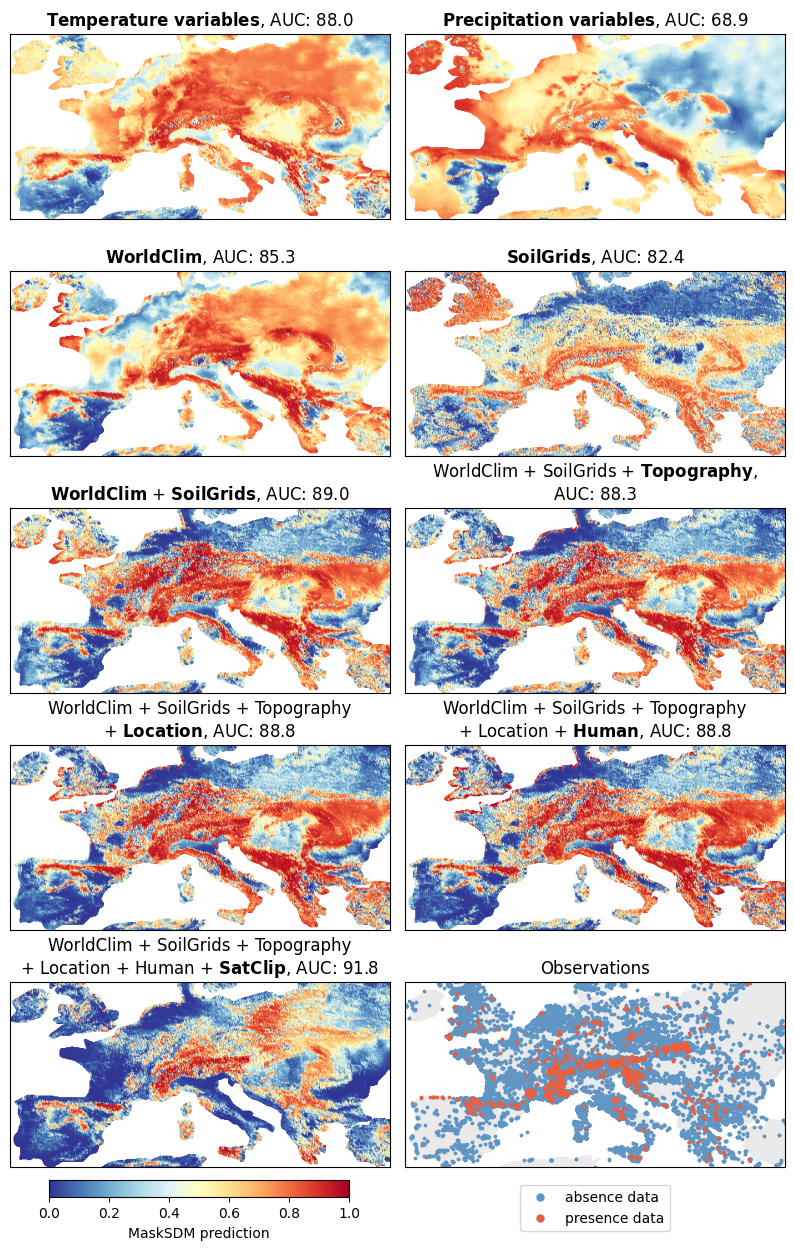

species considered: vaccinium_myrtillus
Number of presence data: 6667
Number of absence data: 88437


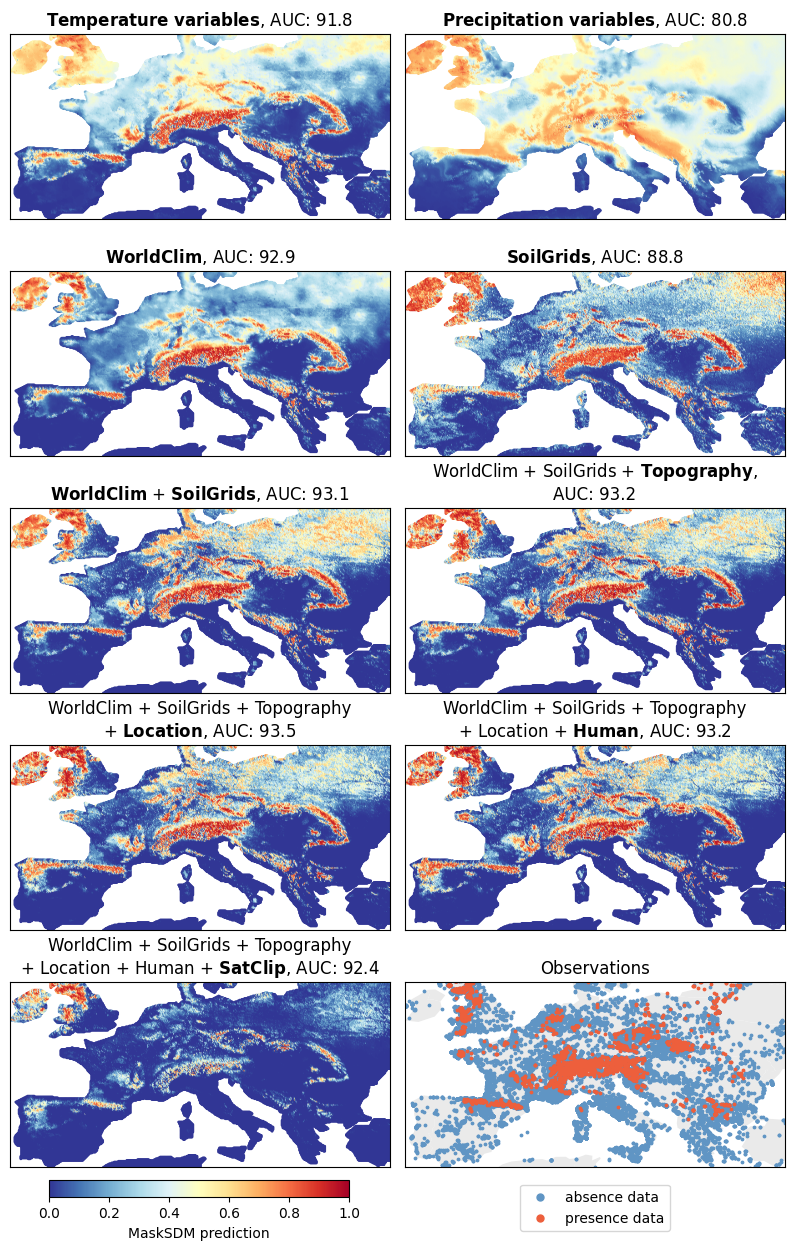

species considered: quercus_ilex
Number of presence data: 1170
Number of absence data: 93934


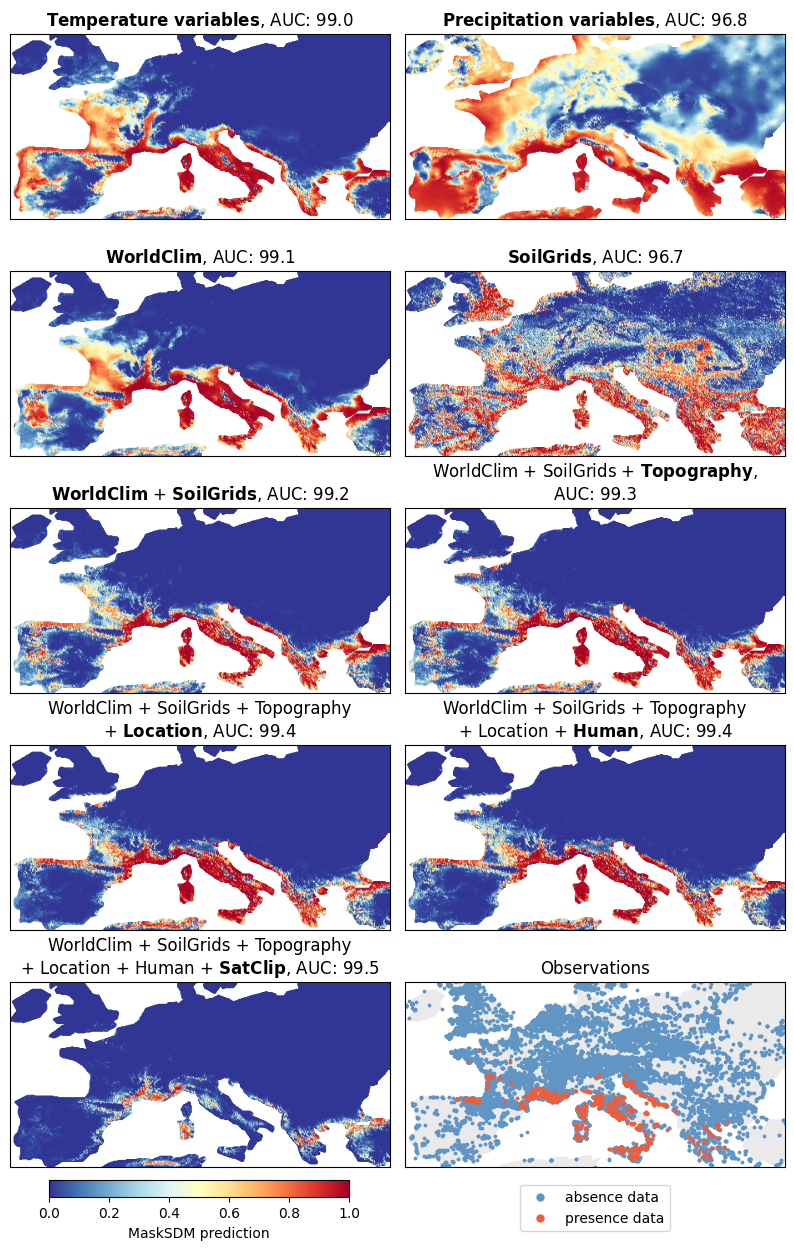

In [ ]:
species_names = ["anthyllis_vulneraria", "vaccinium_myrtillus", "quercus_ilex"]
species_indices = [896, 12268, 10030]

for species_name, species_idx in zip(species_names, species_indices):
    
    species_obs = data["y"][:, species_idx]
    print("species considered:", species_name)
    print("Number of presence data:", species_obs.sum())
    print("Number of absence data:", (~species_obs).sum())
    
    fig, axs = plt.subplots(5, 2, figsize=(10, 14))

    for i in range(5):
        for j in range(2):
        
            ax = axs[i, j]
            legend = False
            world.plot(ax=ax, color=background_color)
            
            if i == 0 and j == 0:
                auc = round(auc_temp[species_idx] * 100, 1)
                ax.set_title(r"$\bf{Temperature\ variables}$, AUC: " + str(auc))
                gdf = gpd.GeoDataFrame(predictions_temp[:,species_idx], geometry=[Point(lon, lat) for lon, lat in land_points_coordinates])
                gdf.plot(ax=ax, markersize=1, column=0, legend=legend, cmap=cmap, norm=norm)
            elif i == 0 and j == 1:
                auc = round(auc_prec[species_idx] * 100, 1)
                ax.set_title(r"$\bf{Precipitation\ variables}$, AUC: " + str(auc))
                gdf = gpd.GeoDataFrame(predictions_prec[:,species_idx], geometry=[Point(lon, lat) for lon, lat in land_points_coordinates])
                gdf.plot(ax=ax, markersize=1, column=0, legend=legend, cmap=cmap, norm=norm)
            elif i == 1 and j == 0:
                auc = round(auc_worldclim[species_idx] * 100, 1)
                ax.set_title(r"$\bf{WorldClim}$, AUC: " + str(auc))
                gdf = gpd.GeoDataFrame(predictions_worldclim[:,species_idx], geometry=[Point(lon, lat) for lon, lat in land_points_coordinates])
                gdf.plot(ax=ax, markersize=1, column=0, legend=legend, cmap=cmap, norm=norm)
            elif i == 1 and j == 1:
                auc = round(auc_soilgrids[species_idx] * 100, 1)          
                ax.set_title(r"$\bf{SoilGrids}$, AUC: " + str(auc))
                gdf = gpd.GeoDataFrame(predictions_soilgrids[:,species_idx], geometry=[Point(lon, lat) for lon, lat in land_points_coordinates])
                gdf.plot(ax=ax, markersize=1, column=0, legend=legend, cmap=cmap, norm=norm)
            elif i == 2 and j == 0:
                auc = round(auc_worldclim_soilgrids[species_idx] * 100, 1)
                ax.set_title(r"$\bf{WorldClim}$" + " + " + r"$\bf{SoilGrids}$, AUC: " + str(auc))
                gdf = gpd.GeoDataFrame(predictions_worldclim_soilgrids[:,species_idx], geometry=[Point(lon, lat) for lon, lat in land_points_coordinates])
                gdf.plot(ax=ax, markersize=1, column=0, legend=legend, cmap=cmap, norm=norm)
            elif i == 2 and j == 1:
                auc = round(auc_worldclim_soilgrids_topo[species_idx] * 100, 1)
                ax.set_title(r"WorldClim + SoilGrids + $\bf{Topography}$," + "\n" + "AUC: " + str(auc))            
                gdf = gpd.GeoDataFrame(predictions_worldclim_soilgrids_topo[:,species_idx], geometry=[Point(lon, lat) for lon, lat in land_points_coordinates])
                gdf.plot(ax=ax, markersize=1, column=0, legend=legend, cmap=cmap, norm=norm)
            elif i == 3 and j == 0:
                auc = round(auc_worldclim_soilgrids_topo_location[species_idx] * 100, 1)
                ax.set_title("WorldClim + SoilGrids + Topography" + "\n" + r"+ $\bf{Location}$, AUC: " + str(auc))
                gdf = gpd.GeoDataFrame(predictions_worldclim_soilgrids_topo_location[:,species_idx], geometry=[Point(lon, lat) for lon, lat in land_points_coordinates])
                gdf.plot(ax=ax, markersize=1, column=0, legend=legend, cmap=cmap, norm=norm)
            elif i == 3 and j == 1:
                auc = round(auc_worldclim_soilgrids_topo_location_human[species_idx] * 100, 1)
                ax.set_title("WorldClim + SoilGrids + Topography" + "\n" + r"+ Location + $\bf{Human}$, AUC: " + str(auc))            
                gdf = gpd.GeoDataFrame(predictions_worldclim_soilgrids_topo_location_human[:,species_idx], geometry=[Point(lon, lat) for lon, lat in land_points_coordinates])
                gdf.plot(ax=ax, markersize=1, column=0, legend=legend, cmap=cmap, norm=norm)
            elif i == 4 and j == 0:
                auc = round(auc_all[species_idx] * 100, 1)
                ax.set_title("WorldClim + SoilGrids + Topography" + "\n" + r"+ Location + Human + $\bf{SatClip}$, AUC: " + str(auc))            
                gdf = gpd.GeoDataFrame(predictions_all[:,species_idx], geometry=[Point(lon, lat) for lon, lat in land_points_coordinates])
                gdf.plot(ax=ax, markersize=1, column=0, legend=legend, cmap=cmap, norm=norm)
            else:
                markersize = 3
                
                ax.set_title("Observations")
                gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lon, lat in coordinates[~species_obs]])
                gdf.plot(ax=ax, color=absence_color, markersize=markersize, label="absence data", legend=True, alpha=alpha)

                gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lon, lat in coordinates[species_obs]])
                gdf.plot(ax=ax, color=presence_color, markersize=markersize, label="presence data", legend=True, alpha=alpha)
                
                ax.legend()
                legend = ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.38))
                # Increase the size of the markers in the legend
                for handle in legend.legend_handles:
                    handle._sizes = [25]
            
            ax.set_xlim((xmin, xmax))
            ax.set_ylim((ymin, ymax))
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

    cbar_ax = fig.add_axes([0.164, 0.018, 0.3, 0.012]) # Position: [left, bottom, width, height]
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('MaskSDM prediction')

    plt.subplots_adjust(wspace=0.04, hspace=-0.13, bottom=0.008)
    plt.savefig(f"figures/prediction_maps_{species_name}.png", dpi=260, bbox_inches='tight')
    plt.show()
    

## Baseline comparison

In [10]:
# MaskSDM
model.load_state_dict(torch.load(f"models/masksdm/epoch_500.pt"))
model.eval()

maskSDM_predictions_avg_temp, _ = process_in_batches(land_points_coordinates, n_features, batch_size, model, device, ["avg_temp"])
maskSDM_predictions_worldclim, _ = process_in_batches(land_points_coordinates, n_features, batch_size, model, device, ["wc"])
maskSDM_predictions_worldclim_soilgrids, _ = process_in_batches(land_points_coordinates, n_features, batch_size, model, device, ["wc", "sg"])
maskSDM_predictions_worldclim_soilgrids_topo_location, _ = process_in_batches(land_points_coordinates, n_features, batch_size, model, device, ["wc", "sg", "topo", "loc"])

In [11]:
# Mean imputing baseline
model.load_state_dict(torch.load(f"models/mean/epoch_18.pt"))
model.eval()

mean_predictions_avg_temp, _ = process_in_batches(land_points_coordinates, n_features, batch_size, model, device, ["avg_temp"], handle_missing_values="mean")
mean_predictions_worldclim, _ = process_in_batches(land_points_coordinates, n_features, batch_size, model, device, ["wc"], handle_missing_values="mean")
mean_predictions_worldclim_soilgrids, _ = process_in_batches(land_points_coordinates, n_features, batch_size, model, device, ["wc", "sg"], handle_missing_values="mean")
mean_predictions_worldclim_soilgrids_topo_location, _ = process_in_batches(land_points_coordinates, n_features, batch_size, model, device, ["wc", "sg", "topo", "loc"], handle_missing_values="mean")

In [12]:
# Oracle baseline
model.load_state_dict(torch.load(f"models/oracle/temp_epoch_7.pt"))
model.eval()
oracle_predictions_avg_temp, _ = process_in_batches(land_points_coordinates, n_features, batch_size, model, device, ["avg_temp"], handle_missing_values="mean")

model.load_state_dict(torch.load(f"models/oracle/wc_epoch_27.pt"))
model.eval()
oracle_predictions_worldclim, _ = process_in_batches(land_points_coordinates, n_features, batch_size, model, device, ["wc"], handle_missing_values="mean")

model.load_state_dict(torch.load(f"models/oracle/wc_sg_epoch_33.pt"))
model.eval()
oracle_predictions_worldclim_soilgrids, _ = process_in_batches(land_points_coordinates, n_features, batch_size, model, device, ["wc", "sg"], handle_missing_values="mean")

model.load_state_dict(torch.load(f"models/oracle/wc_sg_topo_loc_epoch_29.pt"))
model.eval()
oracle_predictions_worldclim_soilgrids_topo_location, _ = process_in_batches(land_points_coordinates, n_features, batch_size, model, device, ["wc", "sg", "topo", "loc"], handle_missing_values="mean")

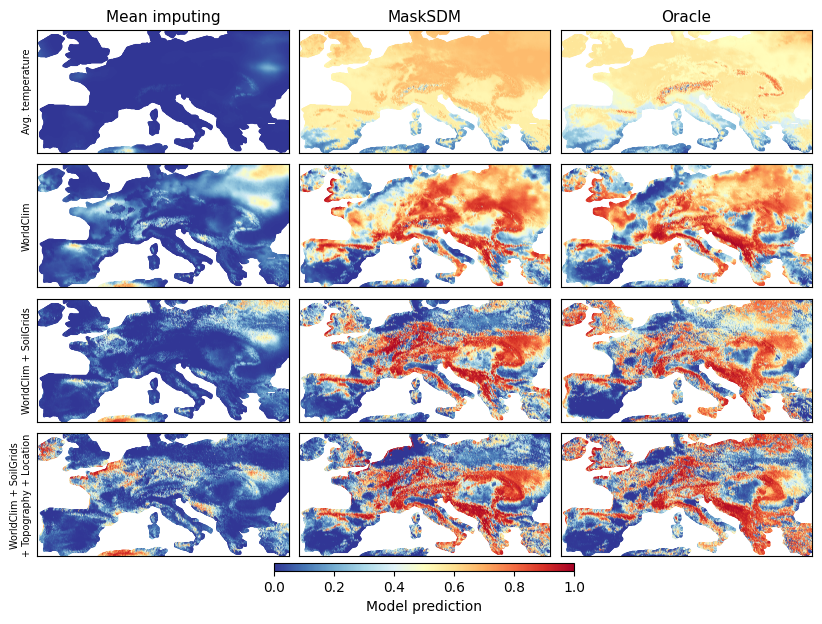

In [13]:
species_idx = species_indices[0]

variables_list = ["Avg. temperature", "WorldClim", "WorldClim + SoilGrids", "WorldClim + SoilGrids\n+ Topography + Location"]
methods = ["Mean imputing", "MaskSDM", "Oracle"]
predictions = [[mean_predictions_avg_temp, mean_predictions_worldclim, mean_predictions_worldclim_soilgrids, mean_predictions_worldclim_soilgrids_topo_location], 
               [maskSDM_predictions_avg_temp, maskSDM_predictions_worldclim, maskSDM_predictions_worldclim_soilgrids, maskSDM_predictions_worldclim_soilgrids_topo_location],
               [oracle_predictions_avg_temp, oracle_predictions_worldclim, oracle_predictions_worldclim_soilgrids, oracle_predictions_worldclim_soilgrids_topo_location]]

fig, axs = plt.subplots(4, 3, figsize=(10, 6.4))
for j in range(3):
    for i, variable in enumerate(variables_list):
        pred = predictions[j][i][:, species_idx]
        ax = axs[i, j]
        legend = False
        world.plot(ax=ax, color=background_color)
        gdf = gpd.GeoDataFrame(pred, geometry=[Point(lon, lat) for lon, lat in land_points_coordinates])
        gdf.plot(markersize=1, column=0, cmap=cmap, norm=norm, ax=axs[i, j])
        
        if j == 0:
            axs[i, j].set_ylabel(f"{variable}", fontsize=7)
        if i == 0:
            axs[i, j].set_title(methods[j], fontsize=11)
        ax.set_xlim((xmin, xmax))
        ax.set_ylim((ymin, ymax))
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])

cbar_ax = fig.add_axes([0.362, 0.010, 0.3, 0.012]) # Position: [left, bottom, width, height]
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Model prediction')

plt.subplots_adjust(wspace=0.04, hspace=-0.13, bottom=0.008)
plt.savefig("figures/oracle_maps_comparison.png", dpi=260, bbox_inches='tight')
plt.show()